In [1]:
import warnings, pickle, os
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna

%load_ext autoreload
%autoreload 1

In [2]:
from utils.evaluation import plot_roc_curves, plot_pr_curves, plot_calibration_curves, plot_alert_rate, plot_confusion_matrix, evaluate_all_outcomes, evaluate_multiple, plot_calibrated_regression_coefficients
from hyperparameter_tuning import tune_lgbm, tune_logisticregression
from utils.data_profiling import ensure_categorical_overlap, drop_exclusive_cols
from dataset import SCIData, SCICols
%aimport utils.evaluation, hyperparameter_tuning, dataset, utils.data_profiling

In [3]:
class Notebook:
    IMAGE_DIR = "images/clinical_models_calibrated_shmi"
    SAVE_IMAGES = True

    RUN_HYPERPARAMETERS = False
    HYPERPARAMETER_TIMEOUT = 60 * 30
    HYPERPARAMETER_TRIALS = 100
    HYPERPARAMETER_NJOBS = -1

    SHAP_PLOTS_MAXDISPLAY = 20
    EVAL_N_RESAMPLES = 99

    MODELS = {}
    EXPLAINERS = {}
    Y_PREDS = {}


try:
    os.makedirs(Notebook.IMAGE_DIR)
except FileExistsError:
    pass


In [4]:
from sklearn.model_selection import train_test_split

sci = (
    SCIData(SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime"))
    .mandate(SCICols.news_data_raw)
)
sci = SCIData(sci[~sci.AdmittedAfterAEC].copy())

scii = (
    sci.derive_critical_event(within=1, return_subcols=True)
    .augment_shmi()
    .encode_ccs_onehot()
    .omit_redundant()
    .raw_news()
    .categorize()
    .onehot_encode_categories()
)

sci_train, sci_test, _, y_test_mortality, _, y_test_criticalcare = train_test_split(
    scii.drop(["DiedWithinThreshold", "CriticalCare"], axis=1),
    scii.DiedWithinThreshold,
    scii.CriticalCare,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)

test_set_n_days = (
    sci.loc[sci_test.index].AdmissionDateTime.max() - sci.loc[sci_test.index].AdmissionDateTime.min()
).days



In [5]:
(X_train_cat, _), (X_test_cat, _) = (
    sci_train.raw_news().xy(
        outcome="CriticalEvent", dropna=False, fillna=False
    ),
    sci_test.raw_news().xy(
        outcome="CriticalEvent", dropna=False, fillna=False
    ),
)
categorical_cols_idx, categorical_cols_dims = X_train_cat.describe_categories()

(X_train_lr, y_train), (X_test_lr, y_test) = (
    sci_train.impute_news().impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True),
    sci_test.impute_news().impute_blood().xy(outcome="CriticalEvent", dropna=False, fillna=True)
)

(X_train_lgbm, _), (X_test_lgbm, _) = (
    sci_train.xy(outcome="CriticalEvent", dropna=False, fillna=False),
    sci_test.xy(outcome="CriticalEvent", dropna=False, fillna=False)
)

(X_train_news, _), (X_test_news, _) = (
    sci_train.impute_news().impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=True,
    ),
    sci_test.impute_news().impute_blood()
    .xy(
        outcome="CriticalEvent",
        x=SCICols.news_data_raw,
        dtype=float,
        dropna=False,
        fillna=True,
    ),
)


In [6]:
from sklearn.metrics import precision_recall_curve


def get_threshold(y_train, y_pred_proba, target=0.85):
    """ Given prediction probabilities, sets the prediction threshold to approach the given target recall
    """

    # Get candidate thresholds from the model, and find the one that gives the best fbeta score
    precision, recall, thresholds = precision_recall_curve(y_train, y_pred_proba)
    closest = thresholds[np.abs(recall - target).argmin()]

    return closest


In [7]:
def benchmark(y_pred, y_pred_proba, modelkey, filekey, tuning=False):
    evaluate_all_outcomes(
        y_test,
        y_test_mortality,
        y_test_criticalcare,
        y_pred,
        y_pred_proba,
        modelkey,
        n_resamples=Notebook.EVAL_N_RESAMPLES,
        save=f"{Notebook.IMAGE_DIR}/eval_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )
    plot_confusion_matrix(
        y_test,
        y_pred,
        plot_title=modelkey,
        save=f"{Notebook.IMAGE_DIR}/matrix_{filekey}.png"
        if Notebook.SAVE_IMAGES
        else None,
    )

    if not tuning:
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)
    else:
        modelkey = f"{modelkey} (tuned)"
        y_pred = np.where(y_pred_proba > get_threshold(y_test, y_pred_proba), 1, 0)
        evaluate_all_outcomes(
            y_test,
            y_test_mortality,
            y_test_criticalcare,
            y_pred,
            y_pred_proba,
            modelkey,
            n_resamples=Notebook.EVAL_N_RESAMPLES,
            save=f"{Notebook.IMAGE_DIR}/eval_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        plot_confusion_matrix(
            y_test,
            y_pred,
            plot_title=modelkey,
            save=f"{Notebook.IMAGE_DIR}/matrix_thresholded_{filekey}.png"
            if Notebook.SAVE_IMAGES
            else None,
        )
        Notebook.Y_PREDS[modelkey] = (y_pred, y_pred_proba)


# Models

## Baseline (NEWS)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Baseline (NEWS),,,,,,,
Critical event,0.979622,0.133240,0.341727,0.191726,0.260274,0.828473,0.828 (0.801-0.856)
Mortality only,0.982853,0.110799,0.663866,0.189904,0.332212,0.930648,0.931 (0.899-0.959)
Critical care,0.978732,0.035063,0.144509,0.056433,0.088968,0.769344,0.769 (0.731-0.806)


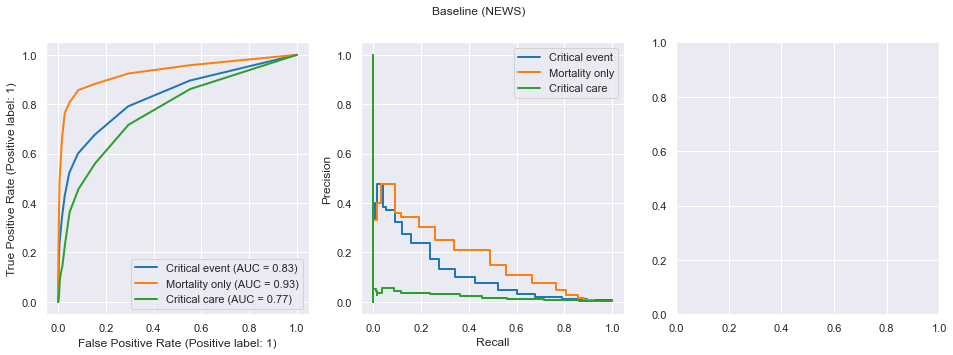

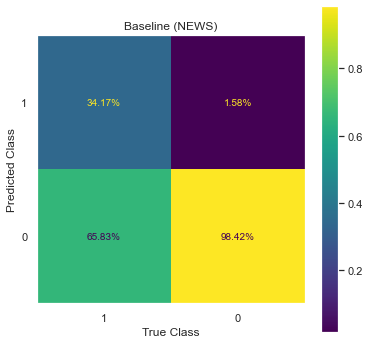

In [8]:
benchmark(
    (sci.loc[sci_test.index].NEWS_score >= 7).to_numpy(),
    sci.loc[sci_test.index].NEWS_score.to_numpy(),
    "Baseline (NEWS)",
    "news",
    tuning=False,
)


## Logistic Regression (NEWS only)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

lr_news_params = {
    'max_iter': 1000,
    'random_state': 42,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'C': 7.85,
    'class_weight': 'balanced',
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_news_params.update(
        tune_logisticregression(
            X_train_news,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "NEWS Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(**lr_news_params), cv=5, method='isotonic'
    ).fit(X_train_news, y_train)
)
Notebook.MODELS[modelkey] = model


BEST PARAMETERS
{'penalty': 'l2', 'C': 7.850629214153356, 'class_weight': 'balanced'}


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
NEWS Logistic Regression,,,,,,,
Critical event,0.992928,0.5,0.014388,0.027972,0.017857,0.838711,0.839 (0.811-0.866)
Mortality only,0.996973,0.5,0.033613,0.062992,0.041322,0.923825,0.924 (0.890-0.952)
Critical care,0.995395,0.0,0.000000,0.000000,0.000000,0.789108,0.789 (0.750-0.823)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
NEWS Logistic Regression (tuned),,,,,,,
Critical event,0.624886,0.015733,0.845324,0.030891,0.073213,0.838711,0.839 (0.811-0.866)
Mortality only,0.622621,0.007431,0.932773,0.014745,0.036009,0.923825,0.924 (0.890-0.952)
Critical care,0.622621,0.009239,0.797688,0.018266,0.044149,0.789108,0.789 (0.750-0.823)


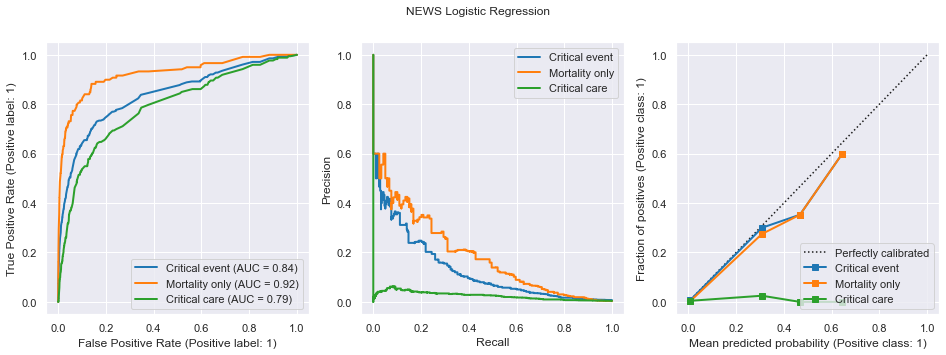

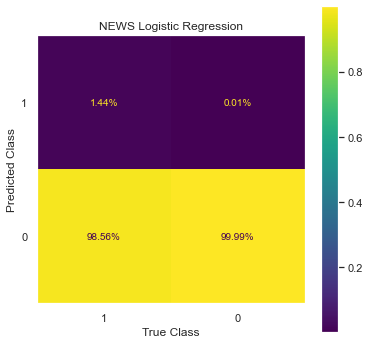

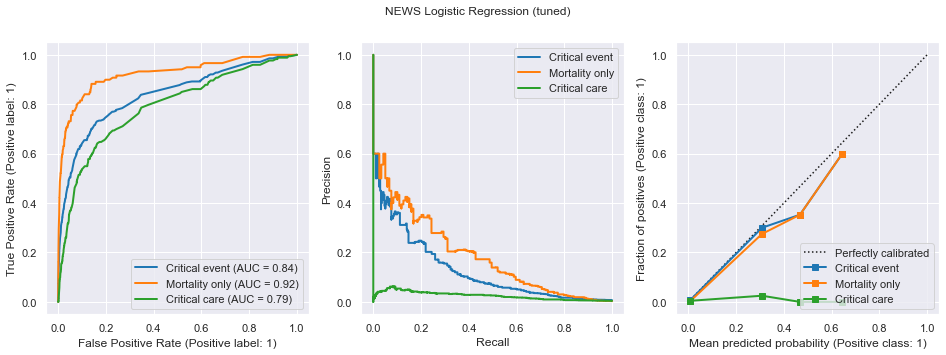

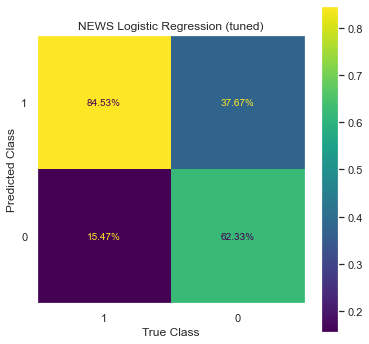

In [10]:
benchmark(
    model.predict(X_test_news),
    model.predict_proba(X_test_news)[:, 1],
    modelkey,
    "news_regression",
    tuning=True,
)



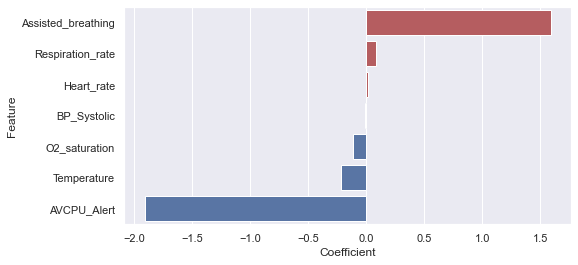

In [11]:
plot_calibrated_regression_coefficients(model, X_train_news.columns, topn=10, figsize=(8,4), save = f'{Notebook.IMAGE_DIR}/logistic_regression_coef.png' if Notebook.SAVE_IMAGES else None)

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

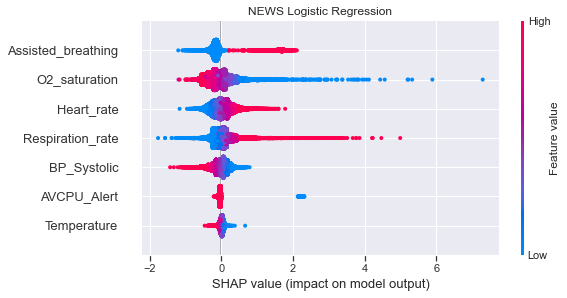

In [12]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_news, feature_perturbation='correlation_dependent'
    )(X_test_news)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_news.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_news_regression.png", bbox_inches="tight"
    )


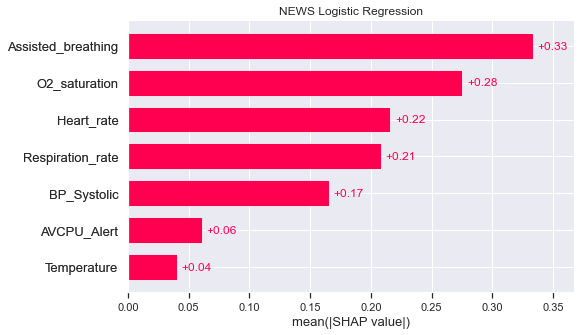

In [13]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("NEWS Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_news_regression.png", bbox_inches="tight"
    )


## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV

lr_params = {
    'max_iter': 10000,
    'random_state': 42,
    'penalty': 'l2',
    'solver': 'lbfgs',
    'C': 9.16316,
    'class_weight': 'balanced',
}


if Notebook.RUN_HYPERPARAMETERS:
    lr_params.update(
        tune_logisticregression(
            X_train_lr,
            y_train,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS,
        )
    )

modelkey = "Logistic Regression"
model = (
    CalibratedClassifierCV(
        LogisticRegression().set_params(**lr_params), cv=5, method='isotonic', n_jobs=-1
    ).fit(X_train_lr, y_train)
)
Notebook.MODELS[modelkey] = model


BEST PARAMETERS
{'penalty': 'l2', 'C': 9.163156226933399, 'class_weight': 'balanced'}


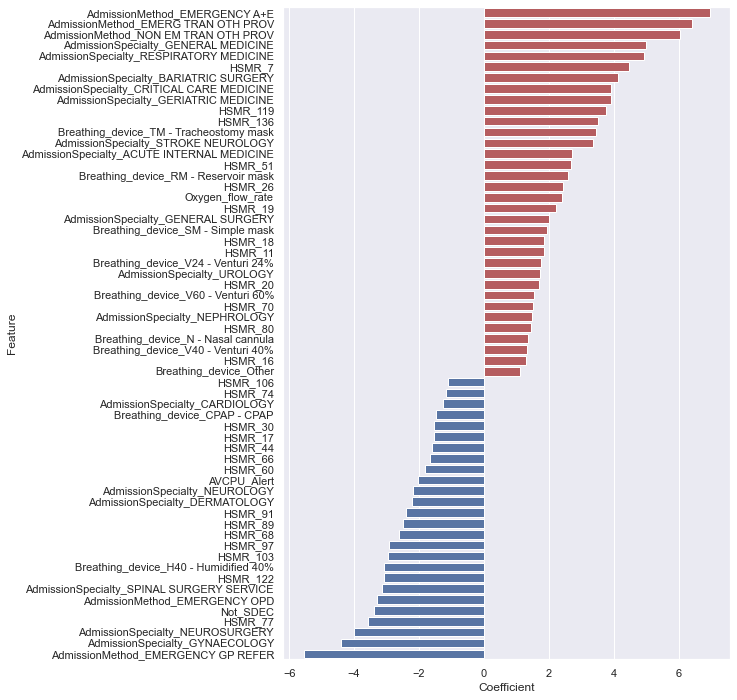

In [15]:
plot_calibrated_regression_coefficients(model, X_train_lr.columns, save = f'{Notebook.IMAGE_DIR}/logistic_regression_coef.png' if Notebook.SAVE_IMAGES else None)

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Logistic Regression,,,,,,,
Critical event,0.992953,0.6,0.010791,0.021201,0.013429,0.917519,0.918 (0.895-0.938)
Mortality only,0.996947,0.4,0.016807,0.032258,0.020790,0.911258,0.911 (0.874-0.943)
Critical care,0.995523,0.2,0.005780,0.011236,0.007174,0.925274,0.925 (0.896-0.949)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Logistic Regression (tuned),,,,,,,
Critical event,0.883993,0.049642,0.848921,0.093800,0.201159,0.917519,0.918 (0.895-0.938)
Mortality only,0.880966,0.020404,0.815126,0.039811,0.092734,0.911258,0.911 (0.874-0.943)
Critical care,0.882441,0.032183,0.884393,0.062107,0.140470,0.925274,0.925 (0.896-0.949)


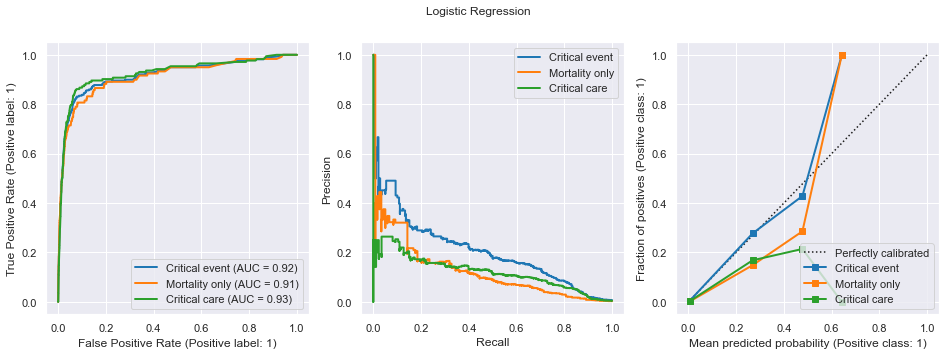

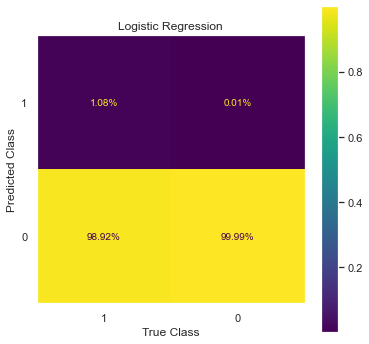

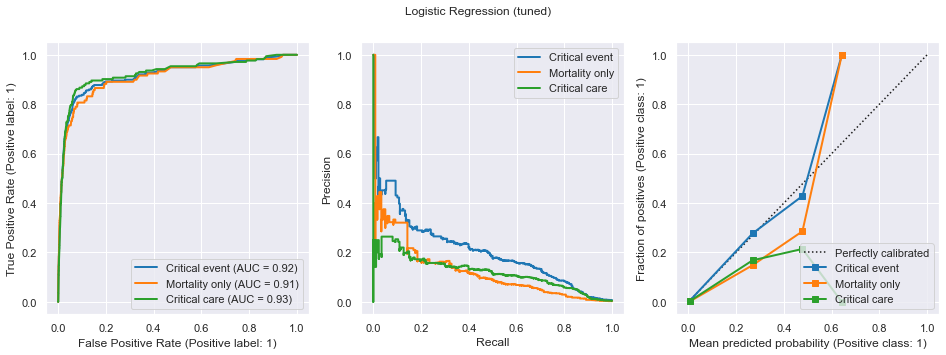

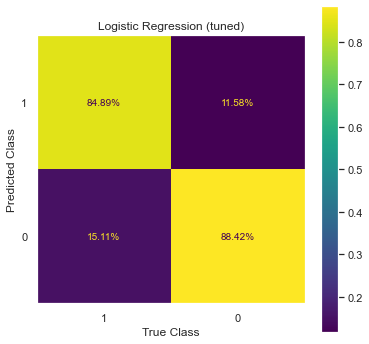

In [16]:
benchmark(
    model.predict(X_test_lr),
    model.predict_proba(X_test_lr)[:, 1],
    modelkey,
    "logistic_regression",
    tuning=True,
)



Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

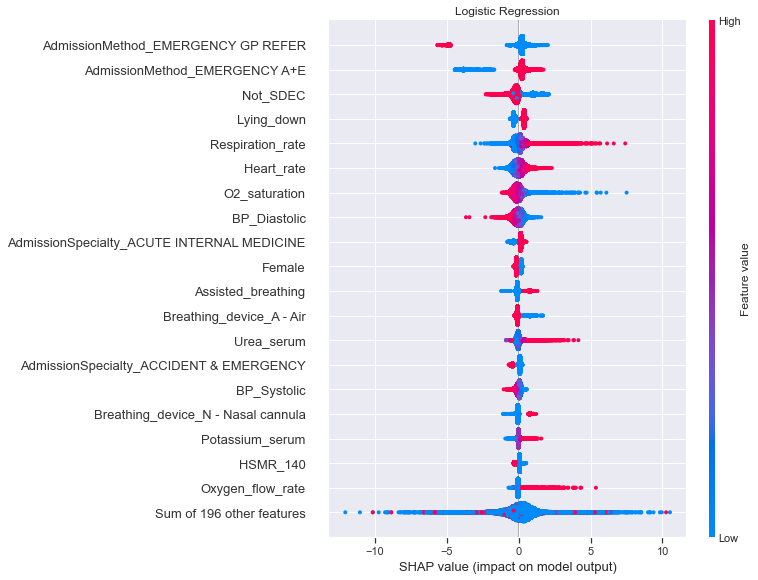

In [17]:
explainers = [
    shap.LinearExplainer(
        _.base_estimator, X_train_lr, feature_perturbation='correlation_dependent'
    )(X_test_lr)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_lr.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

fig = shap.plots.beeswarm(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_swarm_logistic_regression.png", bbox_inches="tight"
    )


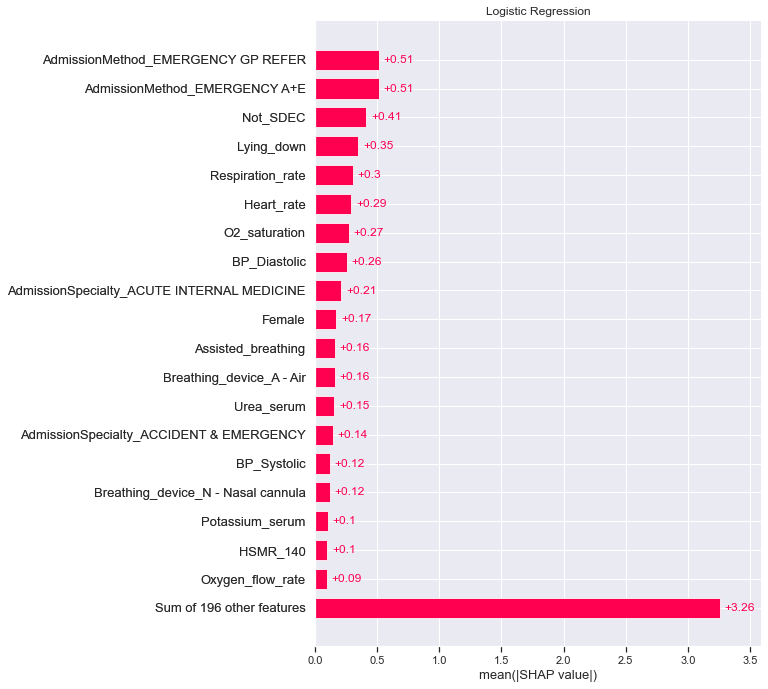

In [18]:
fig = shap.plots.bar(
    shap_values, max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("Logistic Regression")

if Notebook.SAVE_IMAGES:
    plt.savefig(
        f"{Notebook.IMAGE_DIR}/shap_bar_logsitic_regression.png", bbox_inches="tight"
    )


## LightGBM

In [19]:
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

lgbm_params = {
    'LGBM__objective': 'binary',
    'LGBM__verbose_eval': -1,
    'LGBM__random_state': 42,
    'LGBM__metrics': ['l2', 'auc'],
    'LGBM__boosting_type': 'gbdt',
    'LGBM__is_unbalance': True,
    'LGBM__n_jobs': 1,
    'LGBM__feature_pre_filter': False,
    'LGBM__lambda_l1': 0.996,
    'LGBM__lambda_l2': 0.013,
    'LGBM__num_leaves': 6,
    'LGBM__feature_fraction': 0.726,
    'LGBM__bagging_fraction': 0.701,
    'LGBM__bagging_freq': 4,
    'LGBM__min_child_samples': 16,
    'IMB__sampling_strategy': 0.11
}

if Notebook.RUN_HYPERPARAMETERS:
    lgbm_params.update(
        tune_lgbm(
            X_train_lr,
            y_train,
            categorical_cols_idx,
            timeout=Notebook.HYPERPARAMETER_TIMEOUT,
            n_jobs=Notebook.HYPERPARAMETER_NJOBS,
            n_trials=Notebook.HYPERPARAMETER_TRIALS
        )
    )

modelkey = "LightGBM"
model = (
    CalibratedClassifierCV(
        ImbPipeline(
            steps=[
                ("IMB", RandomUnderSampler()), 
                ("LGBM", LGBMClassifier())
            ]
        ).set_params(**lgbm_params),
        cv=5,
        method='isotonic',
        n_jobs=-1
    ).fit(
        X_train_lgbm,
        y_train
    )
)

Notebook.MODELS[modelkey] = model


BEST PARAMETERS
{'LGBM__lambda_l1': 0.9961026720399679, 'LGBM__lambda_l2': 0.012911404168690091, 'LGBM__num_leaves': 6, 'LGBM__feature_fraction': 0.7256545936647886, 'LGBM__bagging_fraction': 0.7014305548375801, 'LGBM__bagging_freq': 4, 'LGBM__min_child_samples': 16, 'IMB__sampling_strategy': 0.1104403414845811}
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.7256545936647886, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7256545936647886
[LightGBM] [Warning] lambda_l1 is set=0.9961026720399679, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9961026720399679
[LightGBM] [Warning] bagging_fraction is set=0.7014305548375801, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7014305548375801
[LightGBM] [Warning] lambda_l2 is set=0.012911404168690091, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012911404168690091
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM,,,,,,,
Critical event,0.992902,0.0,0.0,0.0,0.0,0.941430,0.941 (0.926-0.956)
Mortality only,0.996947,0.0,0.0,0.0,0.0,0.936014,0.936 (0.910-0.960)
Critical care,0.995573,0.0,0.0,0.0,0.0,0.946788,0.947 (0.927-0.964)


,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
LightGBM (tuned),,,,,,,
Critical event,0.932253,0.082604,0.848921,0.150558,0.297304,0.941430,0.941 (0.926-0.956)
Mortality only,0.929327,0.034652,0.831933,0.066532,0.148515,0.936014,0.936 (0.910-0.960)
Critical care,0.930599,0.052853,0.872832,0.099670,0.212736,0.946788,0.947 (0.927-0.964)


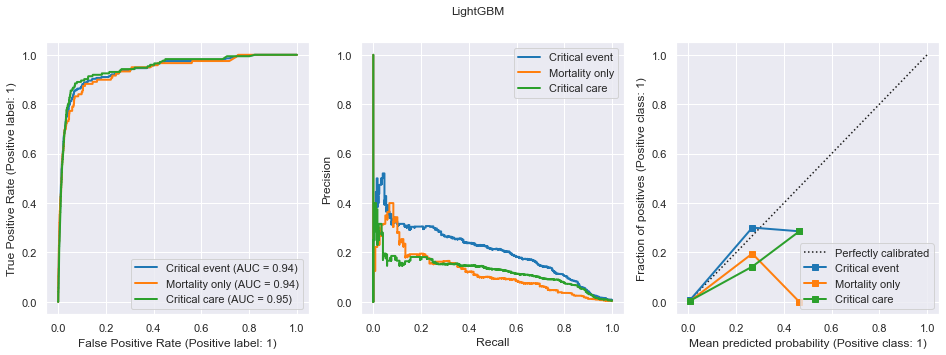

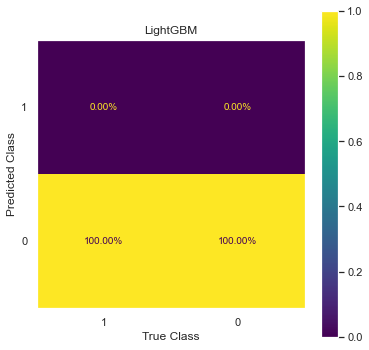

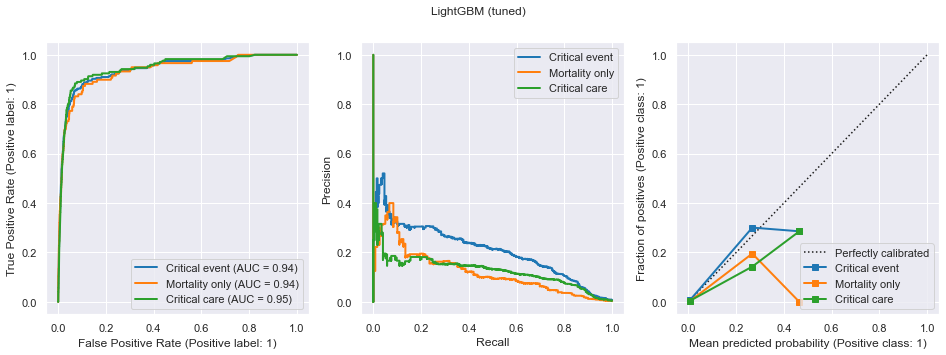

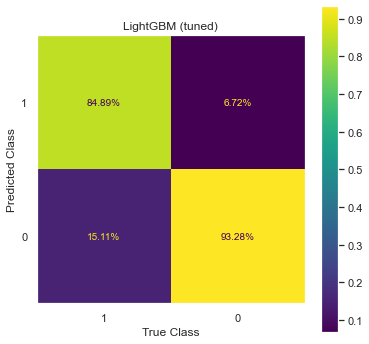

In [20]:
benchmark(
    model.predict(X_test_lgbm),
    model.predict_proba(X_test_lgbm)[:, 1],
    modelkey,
    "lightgbm",
    tuning=True,
)



In [21]:
explainers = [
    shap.TreeExplainer(_.base_estimator['LGBM'])(X_test_lgbm)
    for _ in model.calibrated_classifiers_
]
shap_values = shap.Explanation(
    base_values = np.array([_.base_values for _ in explainers]).mean(axis=0),
    values = np.array([_.values for _ in explainers]).mean(axis=0),
    data = explainers[0].data,
    feature_names = X_train_lgbm.columns
)
Notebook.EXPLAINERS[modelkey] = shap_values

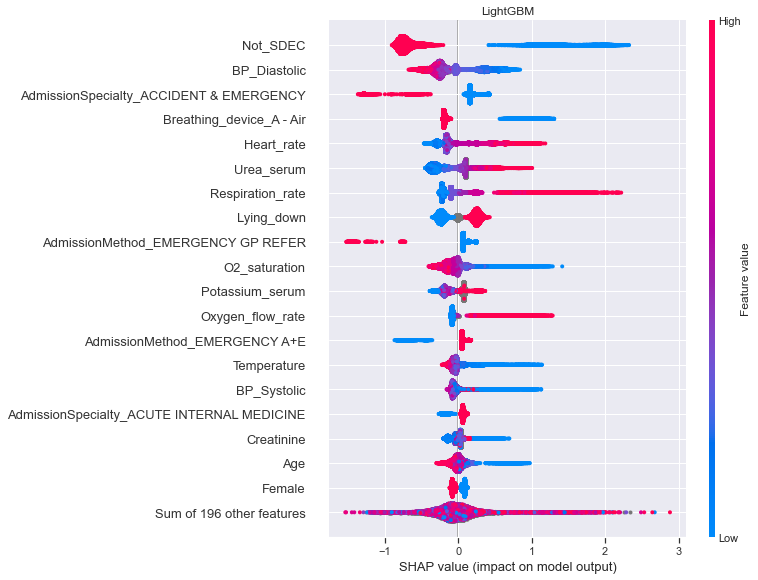

In [22]:
fig = shap.plots.beeswarm(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")
if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_swarm_lightgbm.png", bbox_inches="tight")


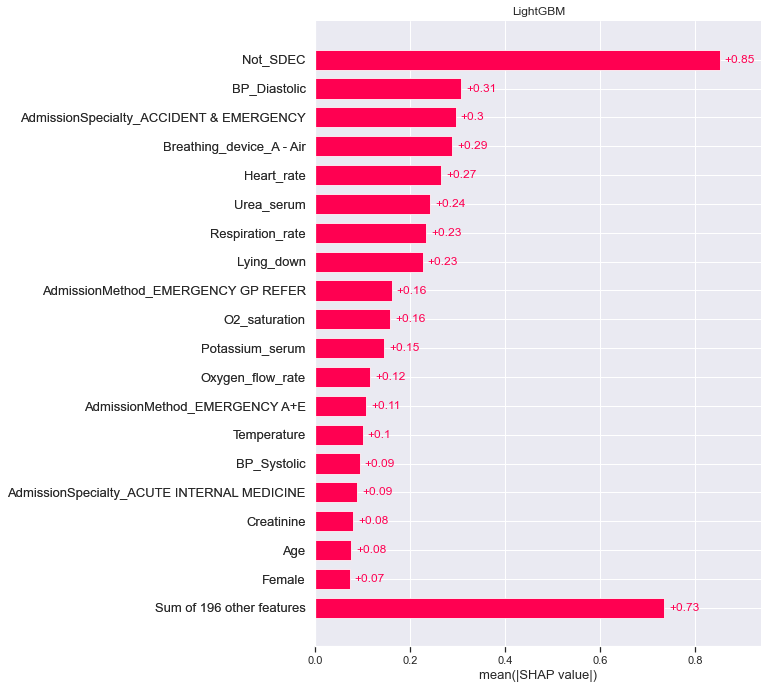

In [23]:
fig = shap.plots.bar(
    shap_values[:, :, 1], max_display=Notebook.SHAP_PLOTS_MAXDISPLAY, show=False
)
plt.title("LightGBM")

if Notebook.SAVE_IMAGES:
    plt.savefig(f"{Notebook.IMAGE_DIR}/shap_bar_lightgbm.png", bbox_inches="tight")


# Comparisons

In [24]:
Notebook.Y_PREDS = dict(reversed(Notebook.Y_PREDS.items()))

,Accuracy,Precision,Recall,F1 Score,F2 Score,AUC,AUC_CI
Model,,,,,,,
LightGBM (tuned),0.932253,0.082604,0.848921,0.150558,0.297304,0.941430,0.941 (0.926-0.956)
Logistic Regression (tuned),0.883993,0.049642,0.848921,0.093800,0.201159,0.917519,0.918 (0.895-0.938)
NEWS Logistic Regression (tuned),0.624886,0.015733,0.845324,0.030891,0.073213,0.838711,0.839 (0.811-0.866)
Baseline (NEWS),0.979622,0.133240,0.341727,0.191726,0.260274,0.828473,0.828 (0.801-0.856)


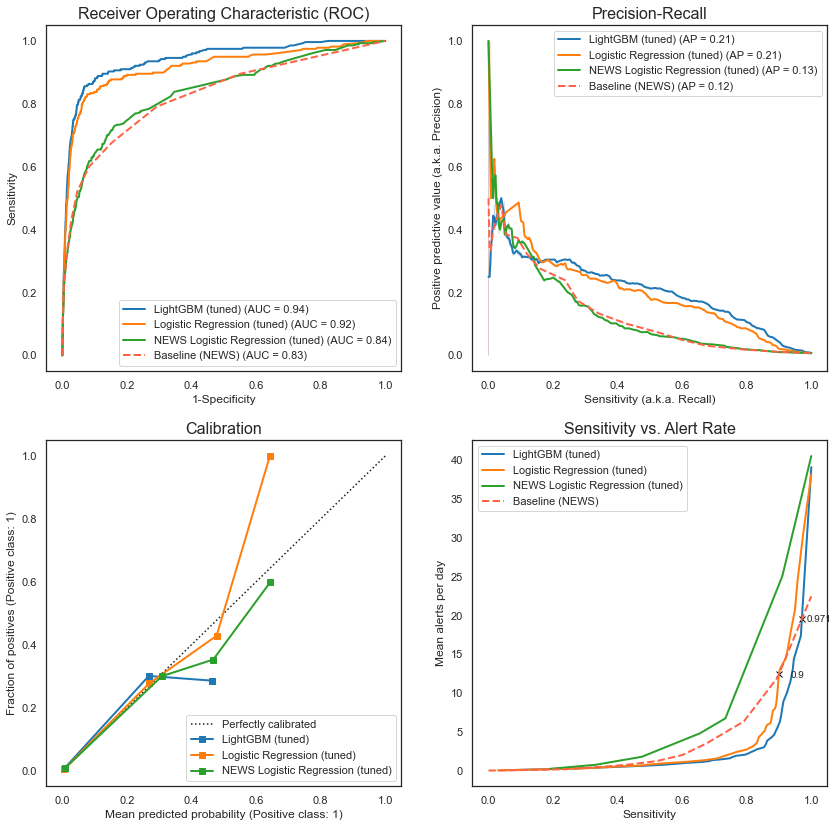

In [25]:
from utils.evaluation import evaluate_multiple

evaluate_multiple(
    y_test,
    Notebook.Y_PREDS,
    news_modelkey="Baseline (NEWS)",
    save=f"{Notebook.IMAGE_DIR}/combined_curves.png" if Notebook.SAVE_IMAGES else None,
    n_resamples=Notebook.EVAL_N_RESAMPLES,
    alert_rate_n_days = test_set_n_days,
)



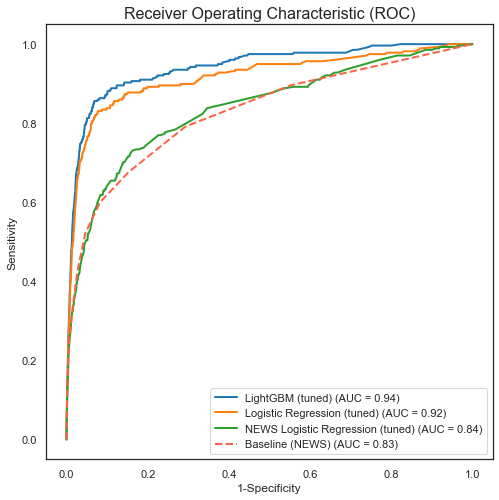

In [26]:
plot_roc_curves(y_test, Notebook.Y_PREDS, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_roc.png' if Notebook.SAVE_IMAGES else None)

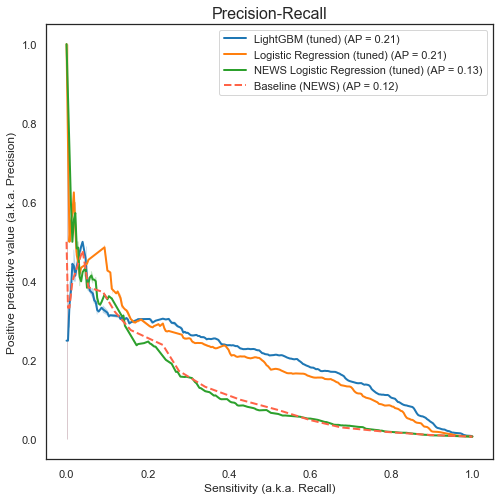

In [27]:
plot_pr_curves(y_test, Notebook.Y_PREDS, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_pr.png' if Notebook.SAVE_IMAGES else None)

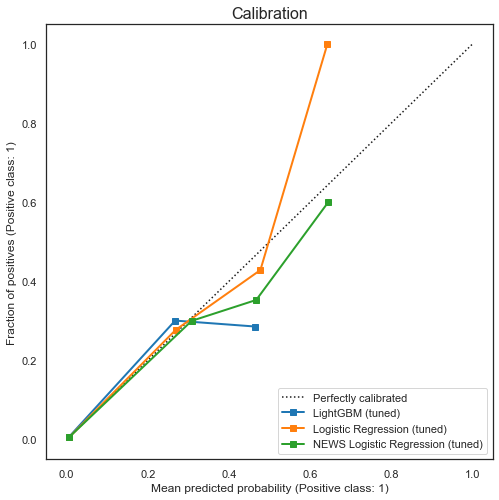

In [28]:
plot_calibration_curves(y_test, Notebook.Y_PREDS, save=f'{Notebook.IMAGE_DIR}/combined_calibration.png' if Notebook.SAVE_IMAGES else None)

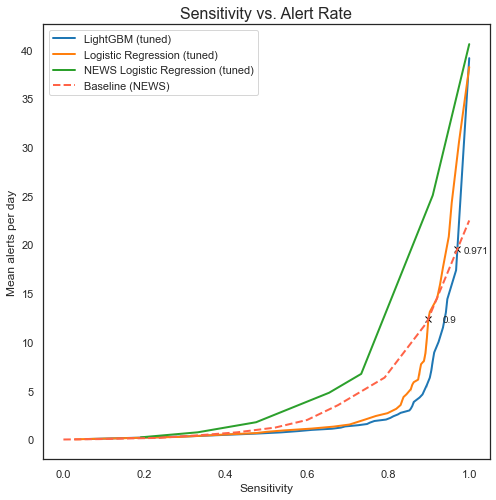

In [29]:
plot_alert_rate(y_test, Notebook.Y_PREDS, test_set_n_days, baseline_key='Baseline (NEWS)', save=f'{Notebook.IMAGE_DIR}/combined_alert_rate.png' if Notebook.SAVE_IMAGES else None)

## SHAP

In [30]:
def patient_force_plots(patient):
    patient_data = X_test_cat.loc[patient].apply(
        lambda x: f"{x:.2f}" if type(x) == np.float64 else x
    )
    patient_idx = X_test_cat.index.get_loc(patient)

    explanations = {
        modelkey: shap_values[patient_idx]
        for modelkey, shap_values in Notebook.EXPLAINERS.items()
        if not modelkey in ["Baseline (NEWS)"]
    }
    for _ in explanations.keys():
        if len(explanations[_].shape) > 1:
            explanations[_] = explanations[_][:, 1]

    sns.set_style("white")
    plt.rc("axes", titlesize=16)
    for modelkey, explanation in explanations.items():
        patient_to_use = patient_data if modelkey != "NEWS Logistic Regression" else patient_data[SCICols.news_data_raw]

        explanation = shap.Explanation(explanation)
        explanation.data = patient_to_use.values

        fig = shap.plots.force(
            explanation,
            feature_names=patient_to_use.index,
            matplotlib=True,
            contribution_threshold=0.08,
            show=False,
            text_rotation=15,
        )

        plt.title(modelkey)
        display(fig)

        if Notebook.SAVE_IMAGES:
            plt.savefig(
                f"{Notebook.IMAGE_DIR}/comaprison_force_plot_{modelkey.replace(' ','')}.png",
                bbox_inches="tight",
            )

        plt.clf()

    sns.set_style("darkgrid")



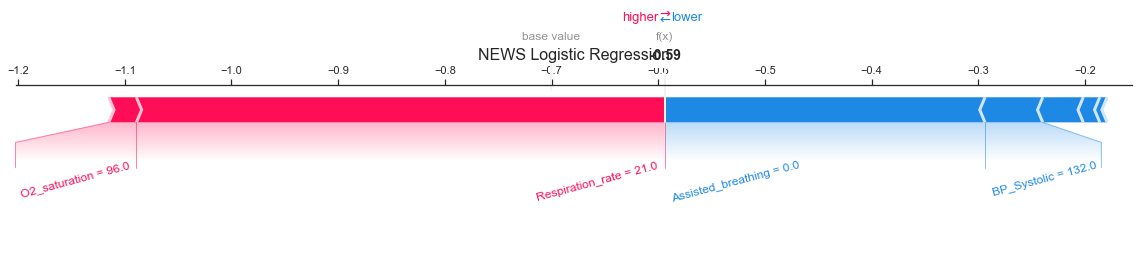

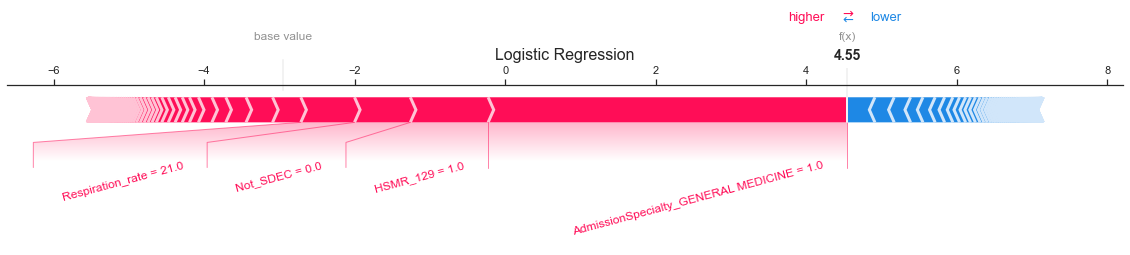

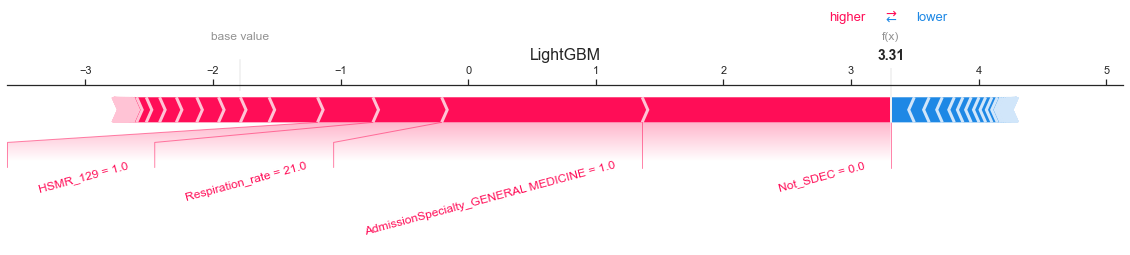

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

<Figure size 1440x216 with 0 Axes>

In [63]:
preds_df = pd.DataFrame({key:val[0] for key, val in Notebook.Y_PREDS.items()}).astype(bool).set_index(y_test.index)
candidate_mask = (
    preds_df['LightGBM (tuned)'] & 
    ~preds_df['Baseline (NEWS)'] & 
    y_test.astype(bool) &
    (X_test_lr.Assisted_breathing == 0)
)
candidates = preds_df[candidate_mask].index

patient_force_plots(candidates[14])

In [81]:
pd.read_hdf('data/ccs.h5', 'shmi').set_index('SHMIGroup').loc[129].SHMIGroupDescription

'Complication of surgical procedures or medical care'

In [82]:
pd.read_hdf('data/icd10.h5', 'ICD10_Codes').loc[sci.loc[candidates[14], SCICols.diagnoses].values[:4]].values

array([['T81',
        'Infection following a procedure, not elsewhere classified'],
       ['Y83',
        'Abnormal reaction/later complication, without mention of misadventure at the time of the procedure, surgical operation with implant of artificial internal device'],
       ['J45', 'Asthma, unspecified'],
       ['F17',
        'Mental and behavioural disorders due to use of tobacco, harmful use']],
      dtype=object)